In [1]:
import pathlib
import pandas as pd
import iso8601.iso8601
import datetime
import matplotlib.pyplot as plt
import collections
import tqdm
import itertools
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)


def round(t):
    t = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second)
    return t


def makehash():
    return collections.defaultdict(makehash)


In [2]:

data_dir = pathlib.Path("Multi_Region")
crh_dir = data_dir.joinpath("cr-h")
cro_dir = data_dir.joinpath("cr-o")
mcf_dir = data_dir.joinpath("mcf")
nep_dir = data_dir.joinpath("neptune")
vsvbp_dir = data_dir.joinpath("vsvbp")

run_dirs = [nep_dir, vsvbp_dir, mcf_dir, cro_dir, crh_dir]
#run_dirs = [nep_dir]

runs = list(range(3))

functions = [
    "compression",
    "dynamic-html",
    "graph-bfs",
    "graph-mst",
     #"pagerank",
    "thumbnailer",
    # "video-processing"
]

# for run in runs:

#function = "compression"
run = 4

In [3]:

result = makehash()

for run_dir, function, run_n in tqdm.tqdm(list(itertools.product(run_dirs, functions, runs))):
    req_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_proxy_metric.csv"))
    req_df['timestamp'] = req_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    req_df['timestamp'] = req_df['timestamp'].map(round)
    min_time = min(req_df['timestamp'])
    max_time = max(req_df['timestamp'])
    req_df['timestamp'] = req_df['timestamp'] - min_time
    req_df = req_df.sort_values('timestamp')

    res_df = pd.read_csv(run_dir.joinpath(f"{function}/{function}_{run_n}_pod_log.csv"))
    res_df = res_df[res_df["container_name"].map(lambda x: function in x)]
    res_df['timestamp'] = res_df['timestamp'].map(lambda x: iso8601.parse_date(x))
    res_df['timestamp'] = res_df['timestamp'].map(round)
    res_df = res_df[res_df['timestamp'] < max_time]
    res_df = res_df[res_df['timestamp'] > min_time]
    res_df['timestamp'] = res_df['timestamp'] - min_time
    res_df = res_df.sort_values('timestamp')

    if run_dir is crh_dir:
        res_df = res_df[~res_df['pod_address'].isna()]
    if run_dir is cro_dir:
        res_df['cpu'] = res_df['cpu'] + np.random.normal(0, 0.5, len(res_df['cpu']))

    cpu = res_df.groupby("timestamp").sum()['cpu'].rolling(20, win_type="triang", min_periods=20).mean()
    rt = req_df.groupby("timestamp").mean()['latency'].rolling(20, win_type="triang", min_periods=20).mean()


    res_df = res_df.merge(pd.DataFrame({'timestamp':req_df['timestamp'].unique()}), on='timestamp', how="right").fillna(method='bfill').fillna(method='ffill')[:]
    p_req= pd.DataFrame({'timestamp':req_df['timestamp'],
                   'ms_timestamp':req_df['latency']})

    p_res= pd.DataFrame({'timestamp':res_df['timestamp'],
                    'ms_timestamp':res_df['response_time']})

    p_req_t=p_req.groupby("timestamp").mean()['ms_timestamp'].rolling(200, win_type="triang", min_periods=20).mean()
    p_req_t=p_req_t.dropna()
    p_res_t=p_res.groupby("timestamp").mean()['ms_timestamp'].rolling(200, win_type="triang", min_periods=20).mean()
    p_res_t=p_res_t.dropna()
    final=p_req_t - p_res_t
    final = [ele for ele in final if ele > 0]

    result[run_dir][function]['delay'][run_n] = final
    result[run_dir][function]['cpu'][run_n] = cpu.to_numpy()
    result[run_dir][function]['rt'][run_n] = rt.to_numpy()


100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


In [4]:
#res_df = res_df.merge(pd.DataFrame({'timestamp':req_df['timestamp'].unique()}), on='timestamp', how="right").fillna(method='bfill').fillna(method='ffill')[:]

In [5]:
# p_req= pd.DataFrame({'timestamp':req_df['timestamp'],
#                    'ms_timestamp':req_df['latency']})

# p_res= pd.DataFrame({'timestamp':res_df['timestamp'],
#                    'ms_timestamp':res_df['response_time']})

# p_req_t=p_req.groupby("timestamp").mean()['ms_timestamp'].rolling(50, win_type="triang", min_periods=20).mean()
# p_req_t=p_req_t.dropna()
# p_res_t=p_res.groupby("timestamp").mean()['ms_timestamp'].rolling(50, win_type="triang", min_periods=20).mean()
# p_res_t=p_res_t.dropna()

In [6]:
# final=p_req_t - p_res_t
# final = [ele for ele in final if ele > 0]
# result[run_dir][function]['delay'][run_n] = final


compression
dynamic-html
graph-bfs
graph-mst
thumbnailer


C:\Users\giecm\AppData\Local\Temp/ipykernel_25708/108184132.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\giecm\AppData\Local\Temp/ipykernel_25708/108184132.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


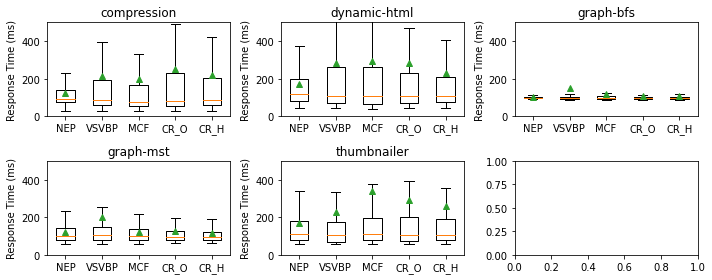

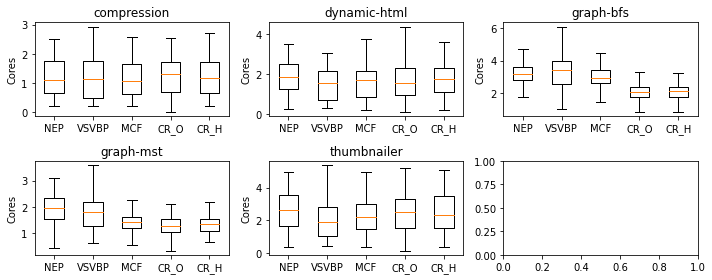

In [7]:
stats_req = pd.DataFrame()
#fig, ax = plt.subplots(ncols=int(len(functions)/2), nrows=2)
fig, ax = plt.subplots(ncols=3, nrows=2)
fig.set_size_inches(10, 4)
for i, function     in enumerate(functions):

    axis = ax[int(i/3)][i % 3]

    data = []
    delay =[]
    for run_dir in run_dirs:
        run_arr = np.concatenate(list(result[run_dir][function]['rt'].values()))
        run_arr = run_arr[~np.isnan(run_arr)]
        data += [run_arr]
        run_del = np.concatenate(list(result[run_dir][function]['delay'].values()))
        delay += [run_del]
        stats_req = stats_req.append({
            'function': function,
            'approach': run_dir,
            'sum': sum(run_arr > (200 if function != "video-processing" else 20000)),
            'len': len(run_arr),
            'mean': np.mean(run_arr),#sum(run_arr)/len(run_arr),
            'median': np.median(run_arr),
            'min': np.min(run_arr),
            'max': np.max(run_arr),
            'std': np.std(run_arr),
            'mse': np.mean(np.abs(run_arr - 100)),
            'ratio': sum(run_arr > (200 if function != "video-processing" else 20000)) / len(run_arr),
            'network_delay': np.mean(run_del),
            'network_delay_sdv': np.std(run_del)
        }, ignore_index=True)

    # data = np.concatenate(data)
    axis.set_title(function)
    axis.boxplot(data, showfliers=False, showmeans=True)
    ##axis.set(xticklabels=['Neptune', 'HPA', 'VPA'])
    axis.set(xticklabels=['NEP', 'VSVBP', 'MCF', 'CR_O', 'CR_H'])
    print(function)
    if function != "video-processing":
        axis.set_ylim([0, 500])
    # else:
        # axis.set_ylim([0, 60000])
    axis.set_ylabel('Response Time (ms)')

fig.tight_layout()
fig.show()
fig.savefig("single_response_time.pdf")
stats_req.to_csv("stats_req.csv")

stats_res = pd.DataFrame()

#fig, ax = plt.subplots(ncols=int(len(functions)/2), nrows=2)
fig, ax = plt.subplots(ncols=3, nrows=2)
fig.set_size_inches(10, 4)
for i, function in enumerate(functions):

    axis = ax[int(i/3)][i % 3]

    data = []
    for run_dir in run_dirs:
        run_arr = np.concatenate(list(result[run_dir][function]['cpu'].values()))
        run_arr = run_arr[~np.isnan(run_arr)]
        data += [run_arr]
        stats_res = stats_res.append({
            'function': function,
            'approach': run_dir,
            'len': len(run_arr),
            'mean': sum(run_arr)/len(run_arr),
            'mse': np.mean(np.abs(run_arr - 100)),
        }, ignore_index=True)

    axis.set_title(function)
    axis.boxplot(data, showfliers=False)
    #axis.set(xticklabels=['Neptune', 'HPA', 'VPA'])
    axis.set(xticklabels=['NEP', 'VSVBP', 'MCF', 'CR_O', 'CR_H'])
    axis.set_ylabel('Cores')

fig.tight_layout()
fig.show()
fig.savefig("single_cores.pdf")
stats_res.to_csv("stats_res.csv")

In [8]:
print("Network delays are here!")
print("remove negative values")
final=p_req_t - p_res_t
final = [ele for ele in final if ele > 0]
np.mean(final)


Network delays are here!
remove negative values


38.22307006451811